#1. Settings

In [ ]:
import os
from zipfile import ZipFile
import struct
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Check TPU connection and settings

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.61.33.26:8470']


#2. Create datasets with TFRecords

Create Datasets from TFRecords. The records were for training, validation, testing and final training with both training and validation data. All data were uploaded in Google Cloud for using TPU in this case.

In [ ]:
# filepath (Google Cloud to use TPU in this case)

filepath_train = 'gs://sabiko_project/956_train.tfrecord'
filepath_val = 'gs://sabiko_project/956_val.tfrecord'
filepath_test = 'gs://sabiko_project/956_test.tfrecord'
filepath_train_val = 'gs://sabiko_project/956_train_val.tfrecord'

In [ ]:
batch_size = 1024
AUTOTUNE = tf.data.AUTOTUNE

# function transforming TFRecord data into a format usable by TensorFlow models.
def parse_batch_example(example):
    features = tf.io.parse_example(example, features={
        "image": tf.io.FixedLenFeature([127, 128, 1], dtype=tf.float32),
        "label": tf.io.FixedLenFeature([956,], dtype=tf.float32)
    })
    x = features["image"]
    y = features["label"]
    return x, y

# create dataset from TFRecords (with shuffle, prefetch)
dataset_train = tf.data.TFRecordDataset(filepath_train, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)
dataset_val = tf.data.TFRecordDataset(filepath_val, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)
dataset_test = tf.data.TFRecordDataset(filepath_test, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)
dataset_train_val = tf.data.TFRecordDataset(filepath_train, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)

 # 3.  Build CNN models

## 3.1 Initial model

### Built a model with only one convolution layer. (filters=32, kernel_size=3, activation='relu')


In [ ]:
import keras
from keras import layers

def create_model():

  inputs = keras.Input(shape=(127,128,1))

  x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
  x = layers.Flatten()(x)
  outputs = layers.Dense(956, activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 125, 126, 32)      320       
                                                                 
 flatten (Flatten)           (None, 504000)            0         
                                                                 
 dense (Dense)               (None, 956)               481824956 
                                                                 
Total params: 481,825,276
Trainable params: 481,825,276
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# callback with early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) # Early stop if val_loss sees no improvement

Train

In [ ]:
history = model.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=20,
  callbacks=[callback]
)

Epoch 1/20
131/131 [==============================] - 110s 765ms/step - loss: 4.4399 - accuracy: 0.2556 - val_loss: 3.4078 - val_accuracy: 0.3721
Epoch 2/20
131/131 [==============================] - 28s 214ms/step - loss: 2.4020 - accuracy: 0.5474 - val_loss: 2.7429 - val_accuracy: 0.4862
Epoch 3/20
131/131 [==============================] - 28s 210ms/step - loss: 1.5909 - accuracy: 0.6906 - val_loss: 2.4846 - val_accuracy: 0.5256
Epoch 4/20
131/131 [==============================] - 26s 201ms/step - loss: 0.9604 - accuracy: 0.8150 - val_loss: 2.3082 - val_accuracy: 0.5507
Epoch 5/20
131/131 [==============================] - 35s 265ms/step - loss: 0.5081 - accuracy: 0.9077 - val_loss: 2.2921 - val_accuracy: 0.5590
Epoch 6/20
131/131 [==============================] - 22s 165ms/step - loss: 0.2325 - accuracy: 0.9628 - val_loss: 2.3480 - val_accuracy: 0.5722
Epoch 7/20
131/131 [==============================] - 22s 167ms/step - loss: 0.0958 - accuracy: 0.9869 - val_loss: 2.5033 - val_a

Plot the training process

In [ ]:
def plot_loss(x):

    history_dict = x.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

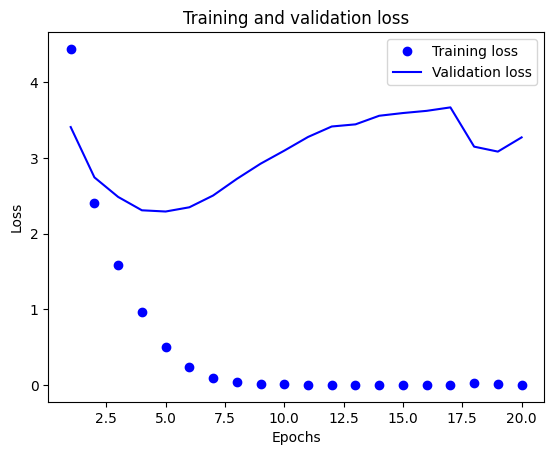

In [ ]:
plot_loss(history)

Test accuracy

In [ ]:
model.evaluate(dataset_test)

10/10 [==============================] - 7s 212ms/step - loss: 3.2561 - accuracy: 0.5829


[3.2560644149780273, 0.5828999876976013]

## 3.2 Add regularization (and MaxPooling)

The initial model showed overfitting. The regularizations were added.

### 3.2.1 MaxPooling2D
MaxPooling2D (pool_size=2) was added after the Conv2D layer, with the expectation of reducing the number of model parameters and mitigating overfitting.

In [ ]:
def create_model2():
  inputs = keras.Input(shape=(127,128,1))

  x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model2 = create_model2()

model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 126, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 124992)            0         
                                                                 
 dense_3 (Dense)             (None, 956)               119493308 
                                                                 
Total params: 119,493,628
Trainable params: 119,493,628
Non-trainable params: 0
_____________________________________________

Train

In [ ]:
history2 = model2.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=20,
  callbacks=[callback]
)

Epoch 1/20
131/131 [==============================] - 30s 176ms/step - loss: 4.6151 - accuracy: 0.2398 - val_loss: 3.3777 - val_accuracy: 0.3800
Epoch 2/20
131/131 [==============================] - 13s 98ms/step - loss: 2.5654 - accuracy: 0.5097 - val_loss: 2.8412 - val_accuracy: 0.4649
Epoch 3/20
131/131 [==============================] - 13s 97ms/step - loss: 2.0150 - accuracy: 0.5981 - val_loss: 2.7219 - val_accuracy: 0.4787
Epoch 4/20
131/131 [==============================] - 13s 94ms/step - loss: 1.6440 - accuracy: 0.6659 - val_loss: 2.5707 - val_accuracy: 0.5052
Epoch 5/20
131/131 [==============================] - 13s 97ms/step - loss: 1.3051 - accuracy: 0.7328 - val_loss: 2.4931 - val_accuracy: 0.5171
Epoch 6/20
131/131 [==============================] - 13s 96ms/step - loss: 0.9886 - accuracy: 0.8003 - val_loss: 2.3783 - val_accuracy: 0.5401
Epoch 7/20
131/131 [==============================] - 13s 95ms/step - loss: 0.7058 - accuracy: 0.8617 - val_loss: 2.2953 - val_accuracy

Plot

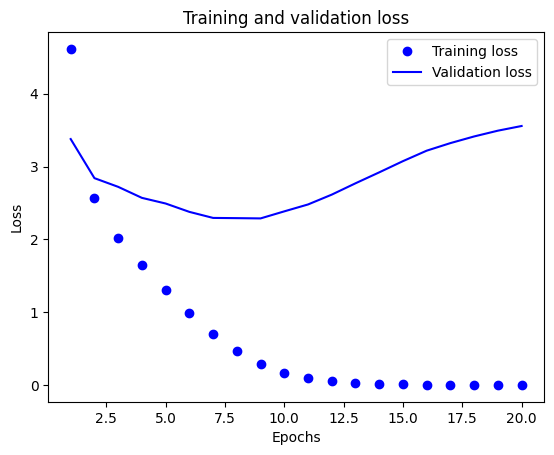

In [ ]:
plot_loss(history2)

Test accuracy

In [ ]:
model2.evaluate(dataset_test)

10/10 [==============================] - 2s 68ms/step - loss: 3.5179 - accuracy: 0.5893


[3.5178756713867188, 0.5892999768257141]

### 3.2.2 L1 regularization

In [ ]:
from tensorflow.keras import regularizers

def create_model3():
  inputs = keras.Input(shape=(127,128,1))

  x = layers.Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.l1(0.01), activation='relu')(inputs) # L1 regularization factor of 0.01
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model3 = create_model3()

model3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 126, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 124992)            0         
                                                                 
 dense_4 (Dense)             (None, 956)               119493308 
                                                                 
Total params: 119,493,628
Trainable params: 119,493,628
Non-trainable params: 0
_____________________________________________

Train

In [ ]:
history3 = model3.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=20,
  callbacks=[callback]
)

Epoch 1/20
131/131 [==============================] - 33s 199ms/step - loss: 4.9435 - accuracy: 0.2341 - val_loss: 3.4621 - val_accuracy: 0.3961
Epoch 2/20
131/131 [==============================] - 13s 97ms/step - loss: 2.7805 - accuracy: 0.5115 - val_loss: 3.0682 - val_accuracy: 0.4515
Epoch 3/20
131/131 [==============================] - 13s 95ms/step - loss: 2.2653 - accuracy: 0.5946 - val_loss: 2.8669 - val_accuracy: 0.4879
Epoch 4/20
131/131 [==============================] - 13s 100ms/step - loss: 1.9799 - accuracy: 0.6440 - val_loss: 2.8612 - val_accuracy: 0.4931
Epoch 5/20
131/131 [==============================] - 13s 97ms/step - loss: 1.7791 - accuracy: 0.6809 - val_loss: 2.8609 - val_accuracy: 0.4976
Epoch 6/20
131/131 [==============================] - 12s 87ms/step - loss: 1.6147 - accuracy: 0.7137 - val_loss: 2.9369 - val_accuracy: 0.4902
Epoch 7/20
131/131 [==============================] - 12s 87ms/step - loss: 1.4810 - accuracy: 0.7399 - val_loss: 2.9871 - val_accurac

Plot

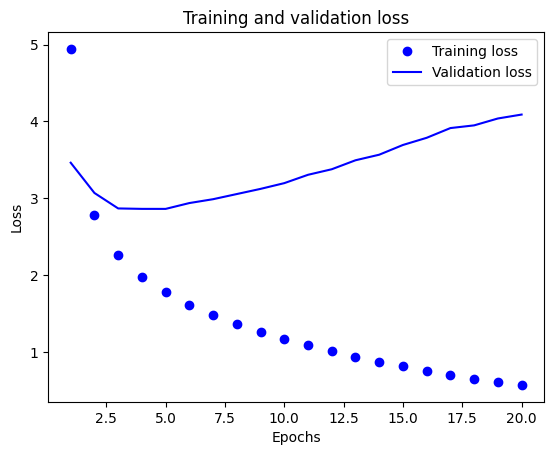

In [ ]:
plot_loss(history3)

Test accuracy

In [ ]:
model1_loss, model1_acc = model3.evaluate(dataset_test)

print('model_acc:', model1_acc)

10/10 [==============================] - 2s 61ms/step - loss: 4.0328 - accuracy: 0.4446
model_acc: 0.444599986076355


### 3.2.3 L2 regularization

In [ ]:
def create_model4():
  inputs = keras.Input(shape=(127,128,1))

  # layers
  x = layers.Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.l2(0.01), activation='relu')(inputs) # L2 regularization factor of 0.01
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model4 = create_model4()

model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 125, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 63, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 124992)            0         
                                                                 
 dense (Dense)               (None, 956)               119493308 
                                                                 
Total params: 119,493,628
Trainable params: 119,493,628
Non-trainable params: 0
_______________________________________________

Train

In [ ]:
history4 = model4.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=20,
  callbacks=[callback]
)

Epoch 1/20
131/131 [==============================] - 83s 563ms/step - loss: 4.5658 - accuracy: 0.2488 - val_loss: 3.2962 - val_accuracy: 0.3987
Epoch 2/20
131/131 [==============================] - 14s 104ms/step - loss: 2.6009 - accuracy: 0.5131 - val_loss: 2.9236 - val_accuracy: 0.4520
Epoch 3/20
131/131 [==============================] - 13s 100ms/step - loss: 2.1028 - accuracy: 0.5935 - val_loss: 2.7896 - val_accuracy: 0.4784
Epoch 4/20
131/131 [==============================] - 13s 100ms/step - loss: 1.8171 - accuracy: 0.6439 - val_loss: 2.7458 - val_accuracy: 0.4859
Epoch 5/20
131/131 [==============================] - 14s 108ms/step - loss: 1.6018 - accuracy: 0.6875 - val_loss: 2.7680 - val_accuracy: 0.4899
Epoch 6/20
131/131 [==============================] - 12s 90ms/step - loss: 1.4214 - accuracy: 0.7275 - val_loss: 2.7920 - val_accuracy: 0.4964
Epoch 7/20
131/131 [==============================] - 12s 92ms/step - loss: 1.2656 - accuracy: 0.7613 - val_loss: 2.8260 - val_accu

Plot

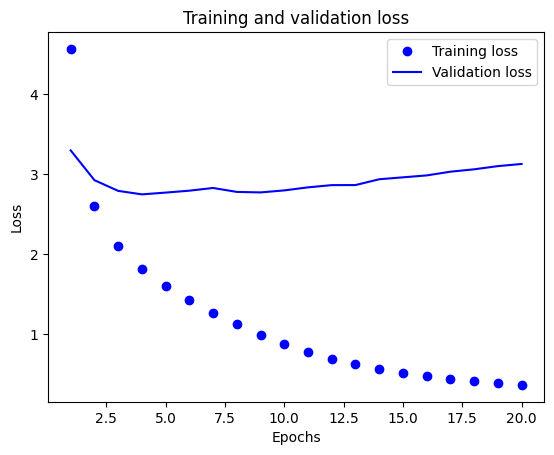

In [ ]:
plot_loss(history4)

Test accuracy

In [ ]:
model1_loss, model1_acc = model4.evaluate(dataset_test)

print('model4_acc:', model1_acc)

10/10 [==============================] - 6s 169ms/step - loss: 3.0698 - accuracy: 0.5177
model4_acc: 0.5177000164985657


### 3.2.4 Dropout

In [ ]:
def create_model5():
  inputs = keras.Input(shape=(127,128,1))

  x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.5)(x) #drop out (rate of 0.5)
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model5 = create_model5()

model5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 126, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 63, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 124992)            0         
                                                                 
 dense_1 (Dense)             (None, 956)               119493308 
                                                           

Train

In [ ]:
history5 = model5.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=20,
  callbacks=[callback]
)

Epoch 1/20
131/131 [==============================] - 32s 186ms/step - loss: 4.5948 - accuracy: 0.2432 - val_loss: 3.2131 - val_accuracy: 0.4034
Epoch 2/20
131/131 [==============================] - 16s 123ms/step - loss: 2.5652 - accuracy: 0.5070 - val_loss: 2.8111 - val_accuracy: 0.4575
Epoch 3/20
131/131 [==============================] - 14s 105ms/step - loss: 2.0520 - accuracy: 0.5922 - val_loss: 2.6900 - val_accuracy: 0.4833
Epoch 4/20
131/131 [==============================] - 15s 116ms/step - loss: 1.7081 - accuracy: 0.6528 - val_loss: 2.5925 - val_accuracy: 0.4970
Epoch 5/20
131/131 [==============================] - 15s 113ms/step - loss: 1.4120 - accuracy: 0.7097 - val_loss: 2.4977 - val_accuracy: 0.5151
Epoch 6/20
131/131 [==============================] - 15s 114ms/step - loss: 1.1421 - accuracy: 0.7638 - val_loss: 2.4397 - val_accuracy: 0.5296
Epoch 7/20
131/131 [==============================] - 15s 114ms/step - loss: 0.8899 - accuracy: 0.8179 - val_loss: 2.2923 - val_ac

Plot

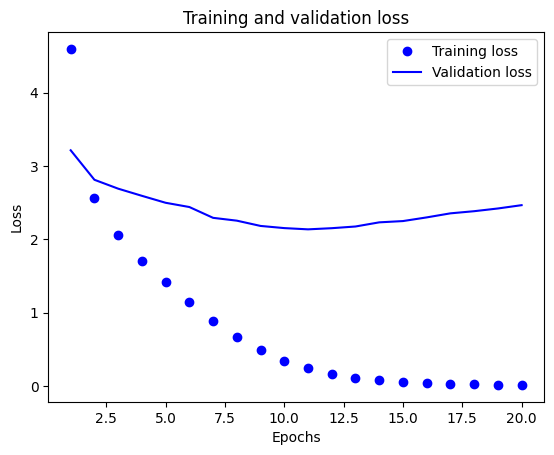

In [ ]:
plot_loss(history5)

Test accuracy

In [ ]:
model1_loss, model1_acc = model5.evaluate(dataset_test)

print('model5_acc:', model1_acc)

10/10 [==============================] - 2s 69ms/step - loss: 2.3861 - accuracy: 0.6353
model5_acc: 0.6352999806404114


### 3.2.5 Batch nomalization (+ Dropout)

batch nomalization between Conv2D layer and Activation function

In [ ]:
def create_model6():
  inputs = keras.Input(shape=(127,128,1))

  x = layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(inputs)
  x = layers.BatchNormalization()(x) # batch nomalization
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.5)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model6 = create_model6()

model6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 125, 126, 32)      288       
                                                                 
 batch_normalization (BatchN  (None, 125, 126, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 63, 32)        0     

Train

In [ ]:
history6 = model6.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=30,
  callbacks=[callback]
)

Epoch 1/30
131/131 [==============================] - 73s 475ms/step - loss: 6.8090 - accuracy: 0.3702 - val_loss: 6.6504 - val_accuracy: 0.4531
Epoch 2/30
131/131 [==============================] - 14s 109ms/step - loss: 0.6814 - accuracy: 0.8490 - val_loss: 5.7209 - val_accuracy: 0.5849
Epoch 3/30
131/131 [==============================] - 14s 107ms/step - loss: 0.1201 - accuracy: 0.9729 - val_loss: 3.4406 - val_accuracy: 0.7076
Epoch 4/30
131/131 [==============================] - 13s 101ms/step - loss: 0.0258 - accuracy: 0.9944 - val_loss: 1.3675 - val_accuracy: 0.7326
Epoch 5/30
131/131 [==============================] - 13s 98ms/step - loss: 0.0099 - accuracy: 0.9979 - val_loss: 1.1793 - val_accuracy: 0.7395
Epoch 6/30
131/131 [==============================] - 13s 96ms/step - loss: 0.0055 - accuracy: 0.9989 - val_loss: 1.3126 - val_accuracy: 0.7476
Epoch 7/30
131/131 [==============================] - 12s 92ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 1.3833 - val_accur

Plot

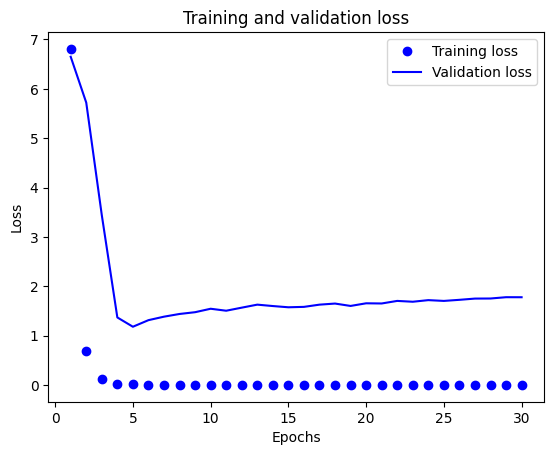

In [ ]:
plot_loss(history6)

Test accuracy

In [ ]:
model1_loss, model1_acc = model6.evaluate(dataset_test)

print('model6_acc:', model1_acc)

10/10 [==============================] - 5s 160ms/step - loss: 1.7105 - accuracy: 0.7633
model6_acc: 0.7633000016212463


### 3.2.6 Increase dropout rate to 0.7 (+ Batch normalization)

In [ ]:
def create_model7():
  inputs = keras.Input(shape=(127,128,1))

  x = layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(inputs)
  x = layers.BatchNormalization()(x) # batch nomalization
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out rate of 0.7
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model7 = create_model7()

model7.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 126, 32)      288       
                                                                 
 batch_normalization_1 (Batc  (None, 125, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 125, 126, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 63, 32)        0   

Train

In [ ]:
history7 = model7.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=30,
  callbacks=[callback]
)

Epoch 1/30
131/131 [==============================] - 34s 179ms/step - loss: 5.7074 - accuracy: 0.3367 - val_loss: 6.5729 - val_accuracy: 0.1399
Epoch 2/30
131/131 [==============================] - 14s 106ms/step - loss: 1.0402 - accuracy: 0.7718 - val_loss: 5.9042 - val_accuracy: 0.2001
Epoch 3/30
131/131 [==============================] - 14s 102ms/step - loss: 0.4040 - accuracy: 0.9033 - val_loss: 4.1402 - val_accuracy: 0.5815
Epoch 4/30
131/131 [==============================] - 14s 103ms/step - loss: 0.1969 - accuracy: 0.9492 - val_loss: 1.8805 - val_accuracy: 0.7075
Epoch 5/30
131/131 [==============================] - 14s 102ms/step - loss: 0.1173 - accuracy: 0.9677 - val_loss: 1.1975 - val_accuracy: 0.7313
Epoch 6/30
131/131 [==============================] - 12s 91ms/step - loss: 0.0785 - accuracy: 0.9779 - val_loss: 1.2638 - val_accuracy: 0.7319
Epoch 7/30
131/131 [==============================] - 12s 89ms/step - loss: 0.0572 - accuracy: 0.9839 - val_loss: 1.2682 - val_accu

Plot

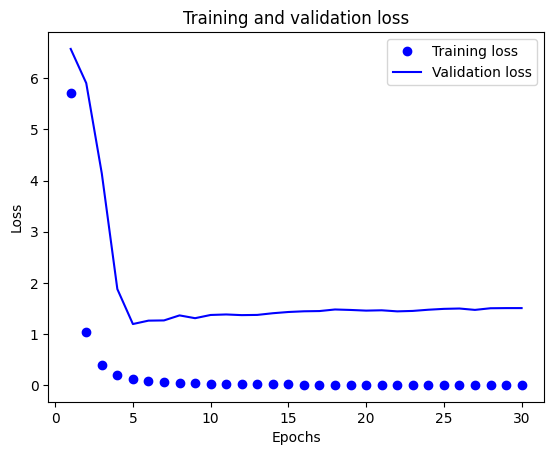

In [ ]:
plot_loss(history7)

Test accuracy

In [ ]:
model1_loss, model1_acc = model7.evaluate(dataset_test)

print('model7_acc:', model1_acc)

10/10 [==============================] - 3s 58ms/step - loss: 1.4791 - accuracy: 0.7673
model7_acc: 0.767300009727478


## 3.3 Add layers

### 3.3.1 Two "Conv2D + MaxPooling2D"

In [ ]:
def create_model8():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [32,32]:
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model8 = create_model8()

model8.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 126, 32)      288       
                                                                 
 batch_normalization_2 (Batc  (None, 125, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 125, 126, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 61, 32)        9216

Train

In [ ]:
history8 = model8.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=30,
  callbacks=[callback]
)

Epoch 1/30
131/131 [==============================] - 27s 142ms/step - loss: 11.1232 - accuracy: 0.1940 - val_loss: 8.8519 - val_accuracy: 6.0000e-04
Epoch 2/30
131/131 [==============================] - 11s 84ms/step - loss: 1.2092 - accuracy: 0.7233 - val_loss: 4.9471 - val_accuracy: 0.1477
Epoch 3/30
131/131 [==============================] - 11s 84ms/step - loss: 0.6214 - accuracy: 0.8455 - val_loss: 3.4735 - val_accuracy: 0.3324
Epoch 4/30
131/131 [==============================] - 11s 84ms/step - loss: 0.4166 - accuracy: 0.8918 - val_loss: 1.4201 - val_accuracy: 0.6809
Epoch 5/30
131/131 [==============================] - 11s 84ms/step - loss: 0.3101 - accuracy: 0.9171 - val_loss: 0.5610 - val_accuracy: 0.8629
Epoch 6/30
131/131 [==============================] - 11s 83ms/step - loss: 0.2406 - accuracy: 0.9329 - val_loss: 0.4455 - val_accuracy: 0.8922
Epoch 7/30
131/131 [==============================] - 11s 82ms/step - loss: 0.1939 - accuracy: 0.9445 - val_loss: 0.4812 - val_acc

Plot

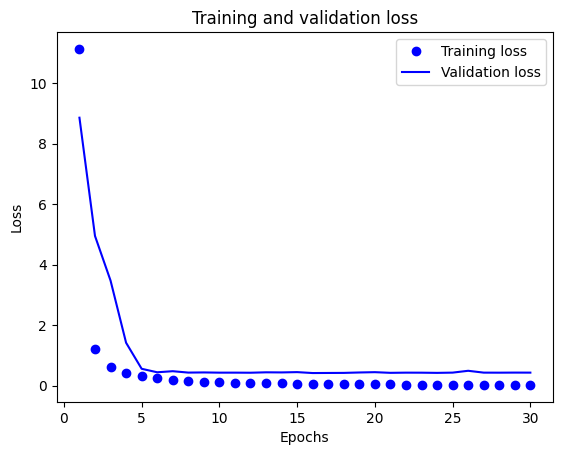

In [ ]:
plot_loss(history8)

Test accuracy

In [ ]:
model1_loss, model1_acc = model8.evaluate(dataset_test)

print('model8_acc:', model1_acc)

10/10 [==============================] - 2s 65ms/step - loss: 0.4089 - accuracy: 0.9166
model8_acc: 0.9165999889373779


### 3.3.2 Three "Conv2D + MaxPooling2D"

In [ ]:
def create_model9():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [32,32,32]:
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model9 = create_model9()

model9.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 126, 32)      288       
                                                                 
 batch_normalization_4 (Batc  (None, 125, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 125, 126, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 61, 32)        9216

Train

In [ ]:
history9 = model9.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=30,
  callbacks=[callback]
)

Epoch 1/30
131/131 [==============================] - 26s 141ms/step - loss: 4.3267 - accuracy: 0.2790 - val_loss: 6.5213 - val_accuracy: 0.0032
Epoch 2/30
131/131 [==============================] - 11s 80ms/step - loss: 1.0090 - accuracy: 0.7528 - val_loss: 7.5872 - val_accuracy: 0.0096
Epoch 3/30
131/131 [==============================] - 11s 81ms/step - loss: 0.5971 - accuracy: 0.8467 - val_loss: 5.5631 - val_accuracy: 0.0994
Epoch 4/30
131/131 [==============================] - 11s 82ms/step - loss: 0.4363 - accuracy: 0.8856 - val_loss: 0.8127 - val_accuracy: 0.8362
Epoch 5/30
131/131 [==============================] - 11s 82ms/step - loss: 0.3528 - accuracy: 0.9057 - val_loss: 0.3483 - val_accuracy: 0.9111
Epoch 6/30
131/131 [==============================] - 11s 81ms/step - loss: 0.2963 - accuracy: 0.9199 - val_loss: 0.2662 - val_accuracy: 0.9300
Epoch 7/30
131/131 [==============================] - 11s 85ms/step - loss: 0.2556 - accuracy: 0.9297 - val_loss: 0.2128 - val_accuracy

Plot

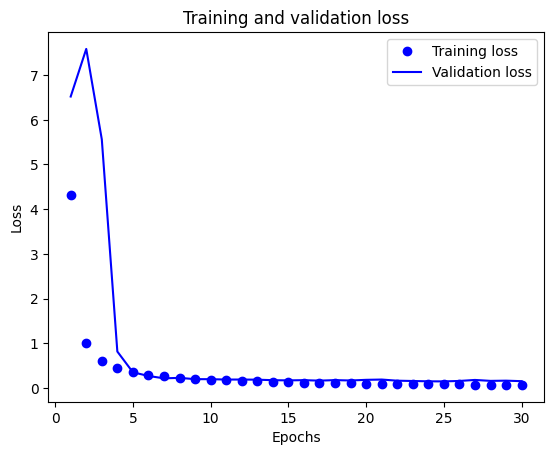

In [ ]:
plot_loss(history9)

Test accuracy

In [ ]:
model1_loss, model1_acc = model9.evaluate(dataset_test)

print('model9_acc:', model1_acc)

10/10 [==============================] - 2s 60ms/step - loss: 0.1427 - accuracy: 0.9631
model9_acc: 0.963100016117096


### 3.3.3 Four "Conv2D + MaxPooling2D"

In [ ]:
def create_model10():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [32,32,32,32]:
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model10 = create_model10()

model10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 125, 126, 32)      288       
                                                                 
 batch_normalization (BatchN  (None, 125, 126, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 61, 32)        9216  

Train

In [ ]:
history10 = model10.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=50,
  callbacks=[callback]
)

Epoch 1/50
131/131 [==============================] - 67s 437ms/step - loss: 5.2198 - accuracy: 0.1227 - val_loss: 6.2054 - val_accuracy: 0.0044
Epoch 2/50
131/131 [==============================] - 11s 80ms/step - loss: 1.5482 - accuracy: 0.6168 - val_loss: 5.3270 - val_accuracy: 0.0724
Epoch 3/50
131/131 [==============================] - 11s 80ms/step - loss: 0.7709 - accuracy: 0.7938 - val_loss: 3.0478 - val_accuracy: 0.4105
Epoch 4/50
131/131 [==============================] - 11s 80ms/step - loss: 0.5371 - accuracy: 0.8520 - val_loss: 0.7519 - val_accuracy: 0.8511
Epoch 5/50
131/131 [==============================] - 11s 79ms/step - loss: 0.4254 - accuracy: 0.8824 - val_loss: 0.2153 - val_accuracy: 0.9528
Epoch 6/50
131/131 [==============================] - 11s 80ms/step - loss: 0.3527 - accuracy: 0.9022 - val_loss: 0.1434 - val_accuracy: 0.9613
Epoch 7/50
131/131 [==============================] - 11s 82ms/step - loss: 0.3109 - accuracy: 0.9134 - val_loss: 0.1282 - val_accuracy

Plot

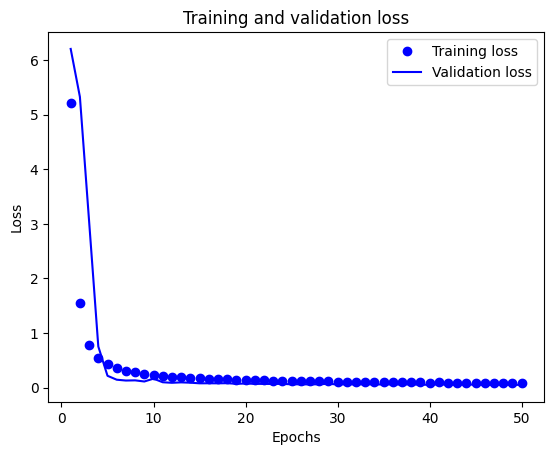

In [ ]:
plot_loss(history10)

Test accuracy

In [ ]:
model1_loss, model1_acc = model10.evaluate(dataset_test)

print('model10_acc:', model1_acc)

10/10 [==============================] - 6s 171ms/step - loss: 0.0477 - accuracy: 0.9863
model10_acc: 0.986299991607666


### 3.3.4 Five "Conv2D + MaxPooling2D"

In [ ]:
def create_model11():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [32,32,32,32,32]:
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model11 = create_model11()

model11.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 126, 32)      288       
                                                                 
 batch_normalization_4 (Batc  (None, 125, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 125, 126, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 61, 32)        9216

Train

In [ ]:
history11 = model11.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 28s 133ms/step - loss: 6.5086 - accuracy: 0.0089 - val_loss: 7.3521 - val_accuracy: 9.0000e-04
Epoch 2/100
131/131 [==============================] - 11s 81ms/step - loss: 4.9956 - accuracy: 0.0743 - val_loss: 6.3368 - val_accuracy: 0.0113
Epoch 3/100
131/131 [==============================] - 11s 84ms/step - loss: 3.7279 - accuracy: 0.2165 - val_loss: 6.0461 - val_accuracy: 0.0210
Epoch 4/100
131/131 [==============================] - 11s 80ms/step - loss: 2.8666 - accuracy: 0.3515 - val_loss: 3.4637 - val_accuracy: 0.2645
Epoch 5/100
131/131 [==============================] - 11s 81ms/step - loss: 2.3114 - accuracy: 0.4518 - val_loss: 0.9416 - val_accuracy: 0.8854
Epoch 6/100
131/131 [==============================] - 11s 80ms/step - loss: 1.9537 - accuracy: 0.5202 - val_loss: 0.6829 - val_accuracy: 0.9114
Epoch 7/100
131/131 [==============================] - 11s 80ms/step - loss: 1.7142 - accuracy: 0.5688 - val_loss: 0.4418 - v

Plot

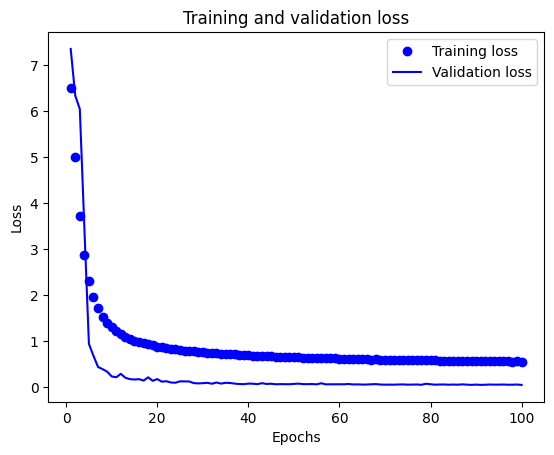

In [ ]:
plot_loss(history11)

Test accuracy

In [ ]:
model1_loss, model1_acc = model11.evaluate(dataset_test)

print('model11_acc:', model1_acc)

10/10 [==============================] - 3s 73ms/step - loss: 0.0493 - accuracy: 0.9857
model11_acc: 0.9857000112533569


## 3.4 Increase number of Conv2D filters

### 3.4.1 64 filters for each Conv2D layer

In [ ]:
def create_model12():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [64,64,64,64,64]: # 64 filters for each Conv2D layer
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model12 = create_model12()

model12.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 126, 64)      576       
                                                                 
 batch_normalization_9 (Batc  (None, 125, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 125, 126, 64)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 61, 64)        3686

Train

In [ ]:
history12 = model12.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 31s 149ms/step - loss: 6.2094 - accuracy: 0.0225 - val_loss: 7.0959 - val_accuracy: 4.0000e-04
Epoch 2/100
131/131 [==============================] - 12s 91ms/step - loss: 3.6503 - accuracy: 0.2381 - val_loss: 8.2680 - val_accuracy: 0.0014
Epoch 3/100
131/131 [==============================] - 13s 96ms/step - loss: 1.9416 - accuracy: 0.5447 - val_loss: 9.2952 - val_accuracy: 0.0038
Epoch 4/100
131/131 [==============================] - 13s 95ms/step - loss: 1.1651 - accuracy: 0.7135 - val_loss: 2.7683 - val_accuracy: 0.3859
Epoch 5/100
131/131 [==============================] - 13s 94ms/step - loss: 0.8090 - accuracy: 0.7946 - val_loss: 0.3417 - val_accuracy: 0.9437
Epoch 6/100
131/131 [==============================] - 12s 92ms/step - loss: 0.6202 - accuracy: 0.8372 - val_loss: 0.1467 - val_accuracy: 0.9739
Epoch 7/100
131/131 [==============================] - 13s 94ms/step - loss: 0.5112 - accuracy: 0.8619 - val_loss: 0.0979 - v

Plot

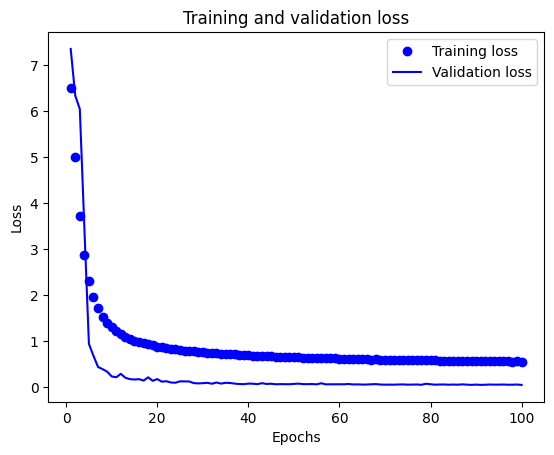

In [ ]:
plot_loss(history11)

Test accuracy

In [ ]:
model1_loss, model1_acc = model12.evaluate(dataset_test)

print('mode11_acc:', model1_acc)

10/10 [==============================] - 2s 59ms/step - loss: 0.0201 - accuracy: 0.9943
mode11_acc: 0.9943000078201294


### 3.4.2 128 filters for each Conv2D layer

In [ ]:
def create_model13():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [128,128,128,128,128]: # 128 filters for each Conv2D layer
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model13 = create_model13()

In [ ]:
model13.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 126, 128)     1152      
                                                                 
 batch_normalization_19 (Bat  (None, 125, 126, 128)    512       
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 125, 126, 128)     0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 63, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 61, 128)       1474

Train

In [ ]:
history13 = model13.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 40s 228ms/step - loss: 5.8614 - accuracy: 0.0477 - val_loss: 7.3754 - val_accuracy: 0.0012
Epoch 2/100
131/131 [==============================] - 17s 128ms/step - loss: 2.2618 - accuracy: 0.4784 - val_loss: 8.8447 - val_accuracy: 0.0014
Epoch 3/100
131/131 [==============================] - 17s 125ms/step - loss: 0.8076 - accuracy: 0.7943 - val_loss: 10.3795 - val_accuracy: 0.0014
Epoch 4/100
131/131 [==============================] - 17s 126ms/step - loss: 0.4250 - accuracy: 0.8894 - val_loss: 5.0560 - val_accuracy: 0.1306
Epoch 5/100
131/131 [==============================] - 16s 125ms/step - loss: 0.2835 - accuracy: 0.9238 - val_loss: 0.8587 - val_accuracy: 0.8216
Epoch 6/100
131/131 [==============================] - 17s 126ms/step - loss: 0.2131 - accuracy: 0.9427 - val_loss: 0.0636 - val_accuracy: 0.9845
Epoch 7/100
131/131 [==============================] - 17s 127ms/step - loss: 0.1757 - accuracy: 0.9520 - val_loss: 0.0460 

Plot

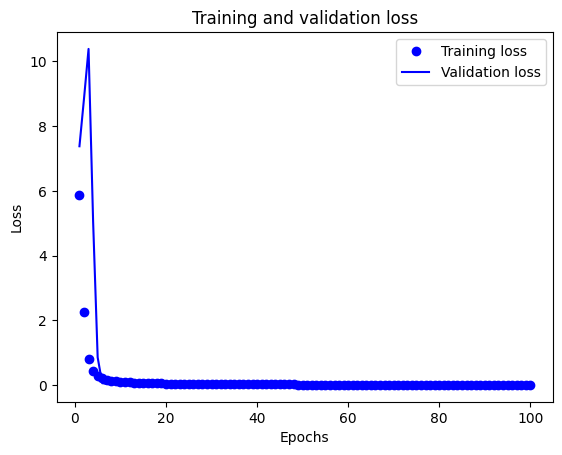

In [ ]:
plot_loss(history13)

Test accuracy

In [ ]:
model1_loss, model1_acc = model13.evaluate(dataset_test)

print('mode13_acc:', model1_acc)

10/10 [==============================] - 4s 67ms/step - loss: 0.0158 - accuracy: 0.9959
mode13_acc: 0.9958999752998352


### 3.4.3 256 filters for each Conv2D layer

In [ ]:
def create_model14():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [256,256,256,256,256]: # 256 filters for each Conv2D layer
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model14 = create_model14()

In [ ]:
model14.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 126, 256)     2304      
                                                                 
 batch_normalization_24 (Bat  (None, 125, 126, 256)    1024      
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 125, 126, 256)     0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 62, 63, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 61, 256)       5898

Train

In [ ]:
history14 = model14.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 73s 434ms/step - loss: 5.4999 - accuracy: 0.0852 - val_loss: 7.3207 - val_accuracy: 0.0019
Epoch 2/100
131/131 [==============================] - 33s 253ms/step - loss: 1.3399 - accuracy: 0.6610 - val_loss: 8.2605 - val_accuracy: 0.0023
Epoch 3/100
131/131 [==============================] - 34s 257ms/step - loss: 0.4080 - accuracy: 0.8885 - val_loss: 8.8031 - val_accuracy: 0.0104
Epoch 4/100
131/131 [==============================] - 34s 255ms/step - loss: 0.2234 - accuracy: 0.9386 - val_loss: 4.6976 - val_accuracy: 0.1632
Epoch 5/100
131/131 [==============================] - 34s 256ms/step - loss: 0.1494 - accuracy: 0.9592 - val_loss: 0.7336 - val_accuracy: 0.8450
Epoch 6/100
131/131 [==============================] - 34s 261ms/step - loss: 0.1120 - accuracy: 0.9694 - val_loss: 0.0705 - val_accuracy: 0.9846
Epoch 7/100
131/131 [==============================] - 33s 254ms/step - loss: 0.0905 - accuracy: 0.9751 - val_loss: 0.0363 -

Plot

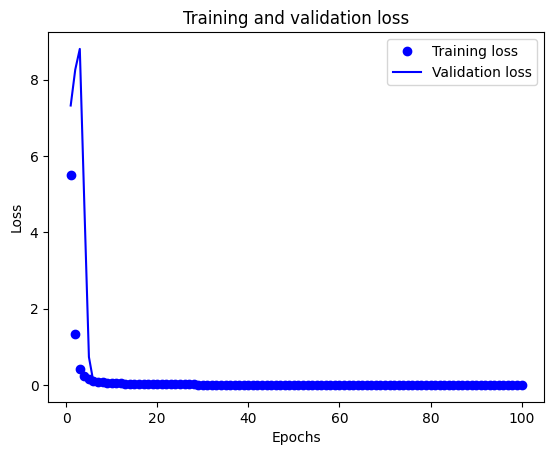

In [ ]:
plot_loss(history14)

Test accuracy

In [ ]:
model1_loss, model1_acc = model14.evaluate(dataset_test)

print('mode14_acc:', model1_acc)

10/10 [==============================] - 2s 84ms/step - loss: 0.0181 - accuracy: 0.9963
mode14_acc: 0.9962999820709229


## 3.5 Change activation function or optimizer

### 3.5.1 Gaussian Error Linear Unit ('gelu') as activation function

In [ ]:
def create_model15():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [256,256,256,256,256]:
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("gelu")(x) # gelu
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model15 = create_model15()

In [ ]:
model15.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_35 (Conv2D)          (None, 125, 126, 256)     2304      
                                                                 
 batch_normalization_35 (Bat  (None, 125, 126, 256)    1024      
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 125, 126, 256)     0         
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 62, 63, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 60, 61, 256)       5898

Train

In [ ]:
history15 = model15.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 69s 421ms/step - loss: 5.0983 - accuracy: 0.1290 - val_loss: 8.7916 - val_accuracy: 9.0000e-04
Epoch 2/100
131/131 [==============================] - 36s 276ms/step - loss: 0.9923 - accuracy: 0.7469 - val_loss: 6.5406 - val_accuracy: 0.0170
Epoch 3/100
131/131 [==============================] - 36s 273ms/step - loss: 0.3141 - accuracy: 0.9165 - val_loss: 6.5760 - val_accuracy: 0.0292
Epoch 4/100
131/131 [==============================] - 36s 275ms/step - loss: 0.1767 - accuracy: 0.9531 - val_loss: 2.2431 - val_accuracy: 0.5815
Epoch 5/100
131/131 [==============================] - 37s 281ms/step - loss: 0.1211 - accuracy: 0.9674 - val_loss: 0.1562 - val_accuracy: 0.9741
Epoch 6/100
131/131 [==============================] - 36s 275ms/step - loss: 0.0928 - accuracy: 0.9754 - val_loss: 0.0404 - val_accuracy: 0.9910
Epoch 7/100
131/131 [==============================] - 36s 274ms/step - loss: 0.0745 - accuracy: 0.9802 - val_loss: 0.02

Test accuracy

In [ ]:
model1_loss, model1_acc = model15.evaluate(dataset_test)

print('mode15_acc:', model1_acc)

10/10 [==============================] - 4s 106ms/step - loss: 0.0174 - accuracy: 0.9964
mode15_acc: 0.996399998664856


### 3.5.2 The Exponential Linear Unit ('elu') as activation function

In [ ]:
def create_model16():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [256,256,256,256,256]:
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("elu")(x) # elu
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model16 = create_model16()

In [ ]:
model16.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 127, 128, 1)]     0         
                                                                 
 conv2d_40 (Conv2D)          (None, 125, 126, 256)     2304      
                                                                 
 batch_normalization_40 (Bat  (None, 125, 126, 256)    1024      
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 125, 126, 256)     0         
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 62, 63, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 60, 61, 256)       5898

Train

In [ ]:
history16 = model16.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 80s 489ms/step - loss: 4.8695 - accuracy: 0.1600 - val_loss: 6.6650 - val_accuracy: 0.0099
Epoch 2/100
131/131 [==============================] - 34s 260ms/step - loss: 1.0156 - accuracy: 0.7457 - val_loss: 6.7292 - val_accuracy: 0.0376
Epoch 3/100
131/131 [==============================] - 35s 267ms/step - loss: 0.3377 - accuracy: 0.9130 - val_loss: 2.9921 - val_accuracy: 0.3385
Epoch 4/100
131/131 [==============================] - 35s 263ms/step - loss: 0.1824 - accuracy: 0.9536 - val_loss: 0.2829 - val_accuracy: 0.9322
Epoch 5/100
131/131 [==============================] - 35s 263ms/step - loss: 0.1233 - accuracy: 0.9685 - val_loss: 0.0550 - val_accuracy: 0.9857
Epoch 6/100
131/131 [==============================] - 34s 262ms/step - loss: 0.0911 - accuracy: 0.9771 - val_loss: 0.0455 - val_accuracy: 0.9887
Epoch 7/100
131/131 [==============================] - 35s 264ms/step - loss: 0.0712 - accuracy: 0.9824 - val_loss: 0.0369 -

Test accuracy

In [ ]:
model1_loss, model1_acc = model16.evaluate(dataset_test)

print('mode16_acc:', model1_acc)

10/10 [==============================] - 4s 147ms/step - loss: 0.0160 - accuracy: 0.9955
mode16_acc: 0.9955000281333923


### 3.5.3 Adaptive Moment Estimation ('adam') optimizer

In [ ]:
def create_model17():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [256,256,256,256,256]:
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("gelu")(x) # gelu
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='adam', # adam
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model17 = create_model17()

Train

In [ ]:
history17 = model17.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 73s 427ms/step - loss: 5.7591 - accuracy: 0.0624 - val_loss: 9.1208 - val_accuracy: 9.0000e-04
Epoch 2/100
131/131 [==============================] - 36s 275ms/step - loss: 1.2941 - accuracy: 0.6801 - val_loss: 11.3163 - val_accuracy: 0.0068
Epoch 3/100
131/131 [==============================] - 36s 275ms/step - loss: 0.3390 - accuracy: 0.9112 - val_loss: 13.4847 - val_accuracy: 0.0125
Epoch 4/100
131/131 [==============================] - 37s 279ms/step - loss: 0.1828 - accuracy: 0.9524 - val_loss: 8.6953 - val_accuracy: 0.0906
Epoch 5/100
131/131 [==============================] - 36s 277ms/step - loss: 0.1238 - accuracy: 0.9677 - val_loss: 0.2993 - val_accuracy: 0.9443
Epoch 6/100
131/131 [==============================] - 37s 279ms/step - loss: 0.0938 - accuracy: 0.9758 - val_loss: 0.0657 - val_accuracy: 0.9868
Epoch 7/100
131/131 [==============================] - 37s 279ms/step - loss: 0.0722 - accuracy: 0.9813 - val_loss: 0.

Test accuracy

In [ ]:
model1_loss, model1_acc = model17.evaluate(dataset_test)

print('mode17_acc:', model1_acc)

10/10 [==============================] - 4s 108ms/step - loss: 0.0144 - accuracy: 0.9961
mode17_acc: 0.9961000084877014


## 3.6 Train the best model with "training + validation" dataset

So far, Model 14 had performed the best accuracy on the test data among all models. The model 18 has the same structure as of the model 14.

In [ ]:
def create_model18():
  inputs = keras.Input(shape=(127,128,1))
  x = inputs

  # layers
  for filter in [256,256,256,256,256]:
    x = layers.Conv2D(filters=filter, kernel_size=3, use_bias=False)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("gelu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Dropout(0.7)(x) #drop out
  x = layers.Flatten()(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model18 = create_model18()

 Train with the 'training + validation' dataset for 52 epochs, as indicated by the best epoch during model 14's training."

In [ ]:
history18 = model18.fit(
  dataset_train_val,
  epochs=52
)

Epoch 1/52
131/131 [==============================] - 94s 584ms/step - loss: 5.0269 - accuracy: 0.1401
Epoch 2/52
131/131 [==============================] - 35s 264ms/step - loss: 0.9535 - accuracy: 0.7544
Epoch 3/52
131/131 [==============================] - 34s 260ms/step - loss: 0.3104 - accuracy: 0.9174
Epoch 4/52
131/131 [==============================] - 34s 259ms/step - loss: 0.1747 - accuracy: 0.9529
Epoch 5/52
131/131 [==============================] - 34s 255ms/step - loss: 0.1202 - accuracy: 0.9678
Epoch 6/52
131/131 [==============================] - 34s 258ms/step - loss: 0.0913 - accuracy: 0.9756
Epoch 7/52
131/131 [==============================] - 34s 260ms/step - loss: 0.0721 - accuracy: 0.9808
Epoch 8/52
131/131 [==============================] - 34s 261ms/step - loss: 0.0595 - accuracy: 0.9843
Epoch 9/52
131/131 [==============================] - 34s 259ms/step - loss: 0.0512 - accuracy: 0.9866
Epoch 10/52
131/131 [==============================] - 34s 260ms/step - l

Test accuracy

In [ ]:
model1_loss, model1_acc = model18.evaluate(dataset_test)

print('mode18_acc:', model1_acc)

10/10 [==============================] - 15s 517ms/step - loss: 0.0138 - accuracy: 0.9968
mode18_acc: 0.9968000054359436


Save the best model

In [ ]:
model18.save('model18_1.h5')